In [1]:
LANGUAGE = 'zul'
EXPERIMENT = 'final_gpt_active_learning'
PREFERRED_GPU = 'cuda:6' # 'cuda:0'

In [2]:
# Prevent WandB from printing summary in cell output
%env WANDB_SILENT=true

env: WANDB_SILENT=true


In [3]:
import os
import sys
import yaml
import copy
import yaml
import json
import wandb
import torch
import datetime
import warnings
import itertools

import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm
from datasets import load_dataset
from sklearn.exceptions import UndefinedMetricWarning
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from openai import APIStatusError, RateLimitError, APIConnectionError
from sklearn.metrics import f1_score
import numpy as np

from openai import OpenAI
from getpass import getpass

torch.cuda.empty_cache()
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [4]:
# Add src module to system path
src_module_path = os.path.abspath('../../../')
if src_module_path not in sys.path:
    sys.path.append(src_module_path)

# Import functions and classes from custom modules
from src.data.preprocess import (
    align_labels_for_many_records,
    TorchDataset,
    balanced_split_for_active_learning
)

from src.query.query_gpt import add_annotation_examples_for_batch, add_annotation_examples
from src.query.prompts import MAIN_PROMPT_FOR_BATCH, MAIN_PROMPT

from src.utils.utils import (predict_sequence_max_uncertainty,
                             batch_indices_to_global_indices,
                             print_classification_report,
                             calculate_micro_f1_for_batches,
                             calculate_macro_f1_for_batches)

from src.models.xlmr_ner import XLMRobertaForNER

In [5]:
# Init openai client
openai_client = OpenAI(api_key=getpass("OPENAI API key:"))

# Weights and Biases login
wandb.login(key=getpass("Weights and Biases API key:"))

True

In [6]:
# Specifying path to the necessary files and folders
PATH_TO_SRC = os.path.abspath('../../../')

CONFIG_PATH = os.path.join(PATH_TO_SRC, "settings/config.yml")

BATCH_ANNOTATION_EXAMPLES_PATH = os.path.join(
    PATH_TO_SRC, 'src/query/ner_examples_all_languages_for_batch.json'
)

SINGLE_ANNOTATION_EXAMPLES_PATH = os.path.join(
    PATH_TO_SRC, 'src/query/ner_examples_all_languages.json'
)

In [7]:
# Reading config file
config = yaml.safe_load(open(CONFIG_PATH))

# Printing out name of the current language
language_name = config['languages_names'][LANGUAGE]
language_name

'Zulu'

In [8]:
batch_examples = add_annotation_examples_for_batch(BATCH_ANNOTATION_EXAMPLES_PATH, language_name)
single_examples = add_annotation_examples(SINGLE_ANNOTATION_EXAMPLES_PATH, language_name)

In [9]:
label_mapping = config['label_mapping']

label_to_index = {value: key for key, value in label_mapping.items()}

# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

# Initialize model
base_model = XLMRobertaForNER(model_name=config['model_name'], 
                         num_labels=len(config['label_mapping'].keys()))

# Choose a GPU to use
default_device = config['gpu_settings']['default_device'] if \
    PREFERRED_GPU=='' else PREFERRED_GPU

# Send model to GPU if cuda is available otherwise use CPU
device = torch.device(default_device if torch.cuda.is_available() else "cpu")
print(device)

base_model.to(device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at Davlan/afro-xlmr-mini and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:6


XLMRobertaForNER(
  (xlmr): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 384, padding_idx=1)
      (position_embeddings): Embedding(514, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
          

In [10]:
ask_gpt_params = {
    'language': language_name,
    #'examples': add_annotation_examples_for_batch(ANNOTATION_EXAMPLES_PATH, language_name),
    'openai_client': openai_client,
    #'user_prompt': MAIN_PROMPT_FOR_BATCH,
    'model': 'gpt-4-0125-preview',
    'temperature': config['foundation_model']['temperature']
}

In [11]:
def ask_gpt_short(user_prompt, language, openai_client, temperature, model,
                  system_prompt=None, max_tokens=1000):

    if system_prompt is None:
        system_prompt = f"You are a named entity labelling expert in {language} language."

    # Save query params
    query_params = {
        'model': model,
        'temperature': temperature,
        'messages': [{"role": "system", "content": system_prompt},
                     {"role": "user", "content": user_prompt}],
        'max_tokens': max_tokens,
    }

    if model == 'gpt-4-1106-preview' or model == 'gpt-4-0125-preview':
        query_params['response_format'] = {"type": "json_object"}

    try:
        # Query the model
        response = openai_client.chat.completions.create(**query_params)
        # Extract model answer
        answer = response.choices[0].message.content
        return answer

    except APIConnectionError as e:
        raise Exception(f"The server could not be reached: {e.__cause__}")
    except RateLimitError as e:
        raise Exception(f"A 429 status code was received: {e}")
    except APIStatusError as e:
        raise Exception(f"Non-200-range status code received: {e.status_code}, {e.response}")

In [12]:
def update_ner_annotations_with_gpt(dataset, batch_examples, single_examples):
    """Updates a dataset with Named Entity Recognition (NER) annotations 
    using predictions from a GPT model."""
    print("Asking GPT to annotate data...")
    indices_to_keep = []
    predicted_ner_tags = []
    true_ner_tags = []

    original_dataset_len = len(dataset)

    for i in range(0, original_dataset_len, 2):
        if i+1 < original_dataset_len:  # Batch of 2
            print(f'\nSample {i+1} and {i+2}:')

            record_0 = dataset[i]
            record_1 = dataset[i+1]

            # 1) Query model
            try:
                # Extract tokens from current record
                tokens = {'record_0': record_0['tokens'], 'record_1': record_1['tokens']}

                batch_user_prompt = MAIN_PROMPT_FOR_BATCH.format(
                    language=language_name,
                    inputs=str(tokens),
                    examples=batch_examples
                )

                # Query the model
                new_labels_gpt = ask_gpt_short(user_prompt=batch_user_prompt, **ask_gpt_params)
                outputs = json.loads(new_labels_gpt)['output']

            except Exception as e:  # If output from the model cannot be extracted
                print(f'Skipping indexes {i} and {i+1}, cannot extract output from the model. Error:')
                print(e, '\n')
                continue

            # Try to extract labels for the first record
            try:
                ner_tags_0 = [t[1] if len(t) > 1 and t[1] is not None else 'O' for t in outputs['record_0']]
                # If number of tokens == number of labels --> save result
                if len(record_0['true_ner_tags']) == len(ner_tags_0):
                    # Replace out-of-scope labels (e.g, 'B-EVENT')
                    ner_tags_0 = [label_to_index.get(t, 0) for t in ner_tags_0]

                    predicted_ner_tags.append(ner_tags_0)
                    true_ner_tags.append(record_0['true_ner_tags'])
                    indices_to_keep.append(i)
                else:
                    print(f'{i} --> different number of tokens and labels.')
            except Exception as e:
                print(f'{i} --> cannot extract NER labels. Error:')
                print(e, '\n')
                continue

            # Try to extract labels for the second record
            try:
                ner_tags_1 = [t[1] if len(t) > 1 and t[1] is not None else 'O' for t in outputs['record_1']]
                # If number of tokens == number of labels --> save result
                if len(record_1['true_ner_tags']) == len(ner_tags_1):
                    # Replace out-of-scope labels (e.g, 'B-EVENT')
                    ner_tags_1 = [label_to_index.get(t, 0) for t in ner_tags_1]

                    predicted_ner_tags.append(ner_tags_1)
                    true_ner_tags.append(record_1['true_ner_tags'])
                    indices_to_keep.append(i+1)
                else:
                    print(f'{i+1} --> different number of tokens and labels.')
            except Exception as e:
                print(f'{i+1} --> cannot extract NER labels. Error:')
                print(e, '\n')
                continue

        else:
            print(f'\nLast sample {i+1}:')

            record = dataset[i]

            # 1) Query model
            try:
                # Extract tokens from current record
                tokens = record['tokens']

                single_user_prompt = MAIN_PROMPT.format(
                    language=language_name,
                    sentence=str(tokens),
                    examples=single_examples
                )

                new_labels_gpt = ask_gpt_short(user_prompt=single_user_prompt, **ask_gpt_params)
                outputs = json.loads(new_labels_gpt)['output']

            except Exception as e:  # If output from the model cannot be extracted
                print(f'{i} --> cannot extract output from the model. Error:')
                print(e, '\n')
                continue

            # Try to extract labels for the first record
            try:
                ner_tags = [t[1] if len(t) > 1 and t[1] is not None else 'O' for t in outputs]
                # If number of tokens == number of labels --> save result
                if len(record['true_ner_tags']) == len(ner_tags):
                    # Replace out-of-scope labels (e.g, 'B-EVENT')
                    ner_tags = [label_to_index.get(t, 0) for t in ner_tags]
                    predicted_ner_tags.append(ner_tags)
                    true_ner_tags.append(record['true_ner_tags'])
                    indices_to_keep.append(i)
                else:
                    print(f'{i} --> different number of tokens and labels.')
            except Exception as e:
                print(f'{i} --> cannot extract NER labels. Error:')
                print(e, '\n')
                continue

    filtered_dataset = dataset.select(indices_to_keep)

    def update_dataset_with_gpt_annotations(example, index):
        example['ner_tags'] = predicted_ner_tags[index]
        return example

    updated_dataset = filtered_dataset.map(update_dataset_with_gpt_annotations, with_indices=True)

    updated_dataset = updated_dataset.map(
        align_labels_for_many_records,
        batched=True,
        fn_kwargs={'tokenizer': tokenizer}
    )

    # Calculate number of annotated and skipped records
    num_annotated_records = len(updated_dataset)
    print(f'{num_annotated_records} records were successfully annotated.')
    if num_annotated_records < original_dataset_len:
        print(f'{original_dataset_len - num_annotated_records} records were skipped.')

    true_ner_tags_flat = list(itertools.chain.from_iterable(true_ner_tags))
    predicted_ner_tags_flat = list(itertools.chain.from_iterable(predicted_ner_tags))
    
    # Calculate F1 score
    f1_score_micro = f1_score(true_ner_tags_flat, predicted_ner_tags_flat, average='micro')
    print(f'F1 micro: {round(f1_score_micro, 2)}')

    return updated_dataset

  0%|          | 0/3 [00:00<?, ?it/s]

Original dataset:
 DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5848
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 836
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1670
    })
})


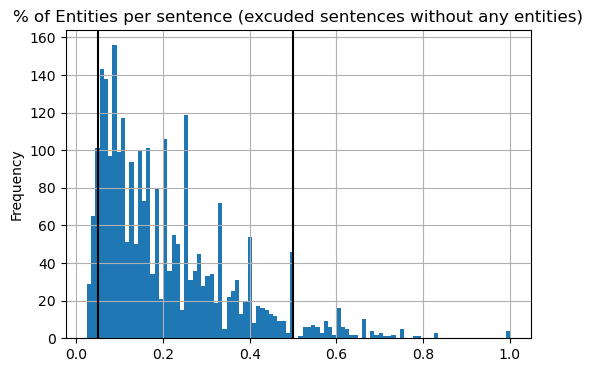

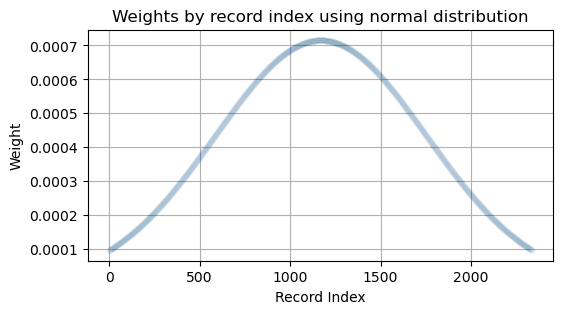

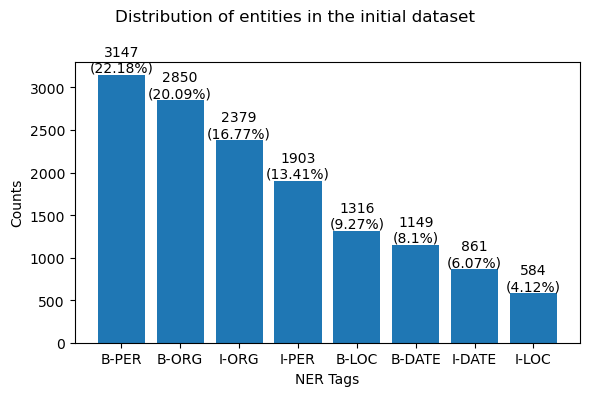

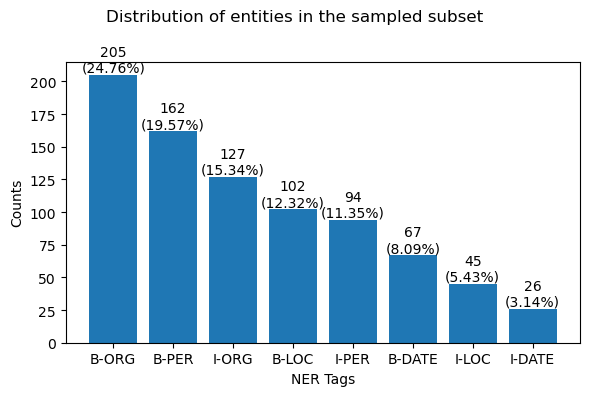

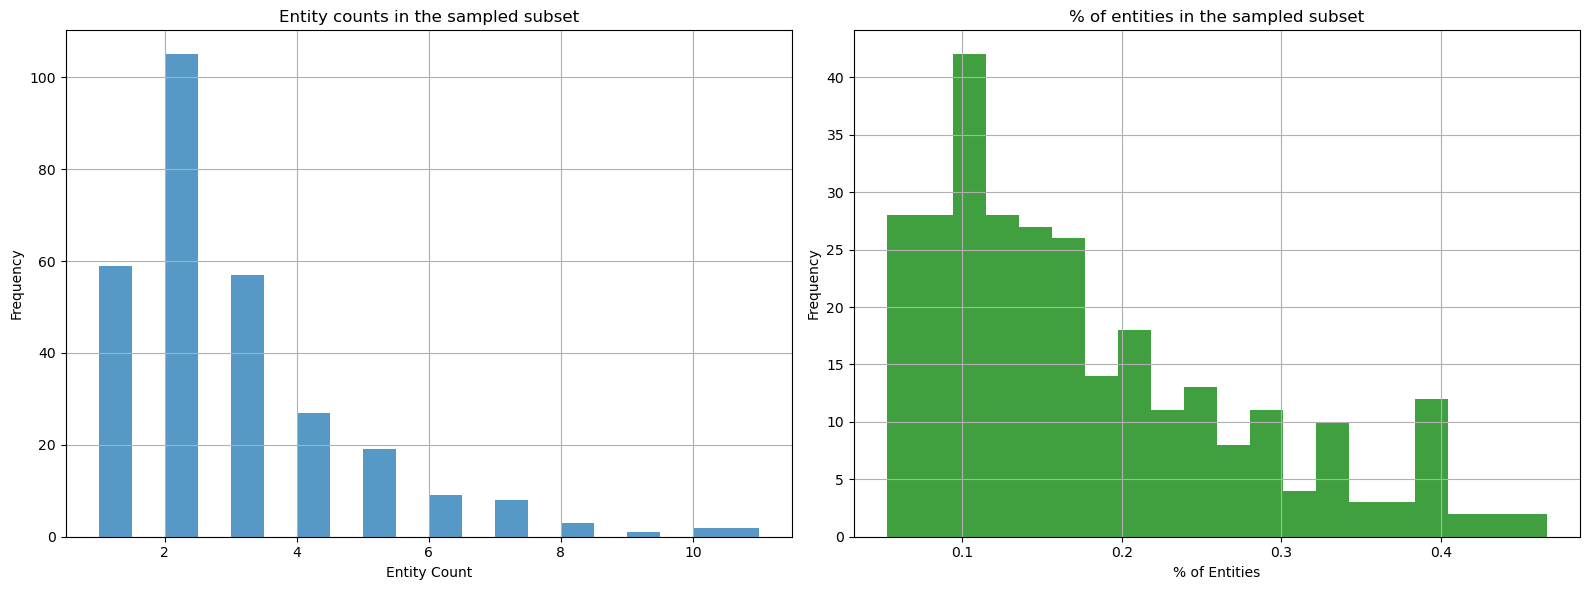

Filter:   0%|          | 0/5848 [00:00<?, ? examples/s]

Split the dataset into initial training (first 5.0%) and active learning (remaining 95.0%).
Overall training dataset size: 5848
Initial training dataset size: 292
Active learning dataset size: 5556


In [13]:
# Download dataset for the specific language 
data = load_dataset(config['dataset'], LANGUAGE)
print("Original dataset:\n", data)

# splitting the data for active learning integration
data = balanced_split_for_active_learning(
    data,
    label_mapping,
    train_key='train',
    split_ratio=config['train_settings']['initial_train_size'],
    verbose=True
)

In [14]:
data = data.map(
    align_labels_for_many_records,
    batched=True,
    fn_kwargs={'tokenizer': tokenizer}
)

Map:   0%|          | 0/5556 [00:00<?, ? examples/s]

In [15]:
# Settings
max_len = config['languages_max_tokens'][LANGUAGE]
print(f'Maximum token length for language {LANGUAGE} is {max_len}')
padding_val = config['tokenizer_settings']['padding_value']

# Convert the datasets.Dataset to a PyTorch Dataset
dataset_init = TorchDataset(data['initial_training'], max_length=max_len, padding_value=padding_val)
dataset_unlabeled = TorchDataset(data['active_learning'], max_length=max_len, padding_value=padding_val)
dataset_test = TorchDataset(data['test'], max_length=max_len, padding_value=padding_val)
dataset_val = TorchDataset(data['validation'],max_length=max_len, padding_value=padding_val)

Maximum token length for language zul is 139


In [16]:
# Settings
batch_size = config['train_settings']['batch_size']
shuffle = config['train_settings']['shuffle']

# Create PyTorch DataLoaders
dataloader_init = DataLoader(dataset_init,
                             batch_size=batch_size,
                             shuffle=shuffle) # Shuffle only training set
dataloader_unlabeled = DataLoader(dataset_unlabeled, batch_size=batch_size)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

In [17]:
def train_ner(model, train_loader, val_loader, device, epochs, lr, updated_dataset_size, num_warmup_steps=5):
    training_history = {
        "train_loss": [],
        "val_loss": [],
        "val_micro_f1": [],
        "val_macro_f1": []
    }
    # Convert lr to float
    lr = float(config['train_settings']['lr'])
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=num_warmup_steps,
                                                num_training_steps=total_steps)

    # Loss function
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    best_val_f1 = 0.0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask=attention_mask)

            logits_reshaped = logits.view(-1, logits.size(-1))
            labels_reshaped = labels.view(-1)

            # Calculate loss
            loss = loss_fn(logits_reshaped, labels_reshaped)

            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_predictions, val_labels = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} [Val]", leave=False):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model(input_ids, attention_mask=attention_mask)
                logits_reshaped = logits.view(-1, logits.size(-1))
                labels_reshaped = labels.view(-1)

                # Calculate loss
                loss = loss_fn(logits_reshaped, labels_reshaped)

                total_val_loss += loss.item()

                predictions = torch.argmax(logits, dim=-1)

                val_predictions.append(predictions.detach())
                val_labels.append(batch['labels'].detach())

        avg_val_loss = total_val_loss / len(val_loader)
        micro_f1 = calculate_micro_f1_for_batches(val_predictions, val_labels, ignore_class=0)
        macro_f1 = calculate_macro_f1_for_batches(val_predictions, val_labels, ignore_class=0)

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {micro_f1:.4f}")

        # Update training history
        training_history["train_loss"].append(avg_train_loss)
        training_history["val_loss"].append(avg_val_loss)
        training_history["val_micro_f1"].append(micro_f1)
        training_history["val_macro_f1"].append(macro_f1)

        # WandB logger
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_micro_f1": micro_f1,
            "val_macro_f1": macro_f1,
            "updated_dataset_size": updated_dataset_size
        })

    return model, training_history

In [18]:
# Prepare WandB for initial training
wandb.init(
    project=f'{EXPERIMENT}_{LANGUAGE}',
    name=f'{LANGUAGE}_initial',
    config={
        'epochs': config['train_settings']['epochs'],
        'learning_rate': config['train_settings']['lr'],
        'num_active_learning_rounds': config['active_learning_settings']['num_rounds']
    },
    settings=wandb.Settings(disable_job_creation=True)
)

# create a new model out of base model for re-training and prevent fine-tuning
base_model_for_train = copy.deepcopy(base_model)

# Initial model training
initial_model, history = train_ner(
    base_model_for_train,
    dataloader_init,
    dataloader_val,
    device,
    epochs=config['train_settings']['epochs'],
    lr=config['train_settings']['lr'],
    updated_dataset_size=len(dataset_init)
)

# Delete the model as it is no longer utilized.
del base_model_for_train

# Disable WandB logger
wandb.finish()

Epoch 1/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.8339 | Val Loss: 1.2353 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.1427 | Val Loss: 0.9925 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 1.0033 | Val Loss: 0.9150 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.9327 | Val Loss: 0.8570 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.8778 | Val Loss: 0.8044 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.8286 | Val Loss: 0.7566 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.7836 | Val Loss: 0.7129 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.7395 | Val Loss: 0.6729 | Val F1: 0.0000


Epoch 9/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.6997 | Val Loss: 0.6359 | Val F1: 0.0000


Epoch 10/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.6666 | Val Loss: 0.6025 | Val F1: 0.0000


Epoch 11/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.6340 | Val Loss: 0.5722 | Val F1: 0.0000


Epoch 12/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.6080 | Val Loss: 0.5447 | Val F1: 0.0000


Epoch 13/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.5817 | Val Loss: 0.5200 | Val F1: 0.0000


Epoch 14/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.5585 | Val Loss: 0.4978 | Val F1: 0.0000


Epoch 15/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.5352 | Val Loss: 0.4780 | Val F1: 0.0000


Epoch 16/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.5218 | Val Loss: 0.4601 | Val F1: 0.0000


Epoch 17/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.5026 | Val Loss: 0.4440 | Val F1: 0.0000


Epoch 18/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.4861 | Val Loss: 0.4296 | Val F1: 0.0000


Epoch 19/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.4732 | Val Loss: 0.4166 | Val F1: 0.0000


Epoch 20/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.4610 | Val Loss: 0.4049 | Val F1: 0.0000


Epoch 21/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.4546 | Val Loss: 0.3937 | Val F1: 0.0000


Epoch 22/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.4360 | Val Loss: 0.3735 | Val F1: 0.0000


Epoch 23/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.3970 | Val Loss: 0.3384 | Val F1: 0.0000


Epoch 24/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.3711 | Val Loss: 0.3252 | Val F1: 0.0000


Epoch 25/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.3534 | Val Loss: 0.3136 | Val F1: 0.0000


Epoch 26/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.3381 | Val Loss: 0.3026 | Val F1: 0.1293


Epoch 27/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.3194 | Val Loss: 0.2936 | Val F1: 0.1557


Epoch 28/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.3071 | Val Loss: 0.2840 | Val F1: 0.1553


Epoch 29/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.2979 | Val Loss: 0.2752 | Val F1: 0.1508


Epoch 30/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.2836 | Val Loss: 0.2689 | Val F1: 0.1479


Epoch 31/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.2757 | Val Loss: 0.2607 | Val F1: 0.1498


Epoch 32/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.2702 | Val Loss: 0.2562 | Val F1: 0.1510


Epoch 33/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.2620 | Val Loss: 0.2515 | Val F1: 0.1549


Epoch 34/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.2560 | Val Loss: 0.2464 | Val F1: 0.1866


Epoch 35/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.2505 | Val Loss: 0.2404 | Val F1: 0.3502


Epoch 36/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.2474 | Val Loss: 0.2330 | Val F1: 0.4171


Epoch 37/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.2375 | Val Loss: 0.2309 | Val F1: 0.4491


Epoch 38/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.2371 | Val Loss: 0.2268 | Val F1: 0.4583


Epoch 39/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.2283 | Val Loss: 0.2216 | Val F1: 0.4703


Epoch 40/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.2246 | Val Loss: 0.2193 | Val F1: 0.4984


Epoch 41/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.2204 | Val Loss: 0.2154 | Val F1: 0.4861


Epoch 42/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.2165 | Val Loss: 0.2149 | Val F1: 0.5104


Epoch 43/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.2152 | Val Loss: 0.2120 | Val F1: 0.4951


Epoch 44/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.2132 | Val Loss: 0.2103 | Val F1: 0.5088


Epoch 45/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.2113 | Val Loss: 0.2086 | Val F1: 0.5061


Epoch 46/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.2088 | Val Loss: 0.2077 | Val F1: 0.5086


Epoch 47/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.2092 | Val Loss: 0.2070 | Val F1: 0.5123


Epoch 48/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.2060 | Val Loss: 0.2061 | Val F1: 0.5151


Epoch 49/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.2080 | Val Loss: 0.2055 | Val F1: 0.5113


Epoch 50/50 [Train]:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.2053 | Val Loss: 0.2053 | Val F1: 0.5108


In [19]:
# Model evaluation before re-training
print_classification_report(config, initial_model, dataloader_test, device, ignore_index=-100, ignore_class=0)

[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.00      0.00      0.00       926
       B-LOC       0.47      0.77      0.58      1288
       B-ORG       0.52      0.77      0.62      1099
       B-PER       0.66      0.91      0.76      2753
      I-DATE       0.00      0.00      0.00       412
       I-LOC       0.00      0.00      0.00       237
       I-ORG       0.00      0.00      0.00       533
       I-PER       0.00      0.00      0.00      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.52      8405
   macro avg       0.18      0.27      0.22      8405
weighted avg       0.35      0.52      0.42      8405



In [20]:
# Select initial model as best model for the first round of active learning
best_model = copy.deepcopy(initial_model)

# Delete the model as it is no longer utilized.
del initial_model

# Use initial dataset to be combined with re-annotated uncertain samples for first round of active learning 
combined_dataset = copy.deepcopy(dataset_init)

In [21]:
# Active learning framework
for active_learning_round in range(config['active_learning_settings']['num_rounds']):
    print(10*"=" + f" Active Learning - Round {active_learning_round+1} " + 10*"=")
    # Prepare WandB for active learning
    wandb.init(
        project=f'{EXPERIMENT}_{LANGUAGE}',
        name=f'{LANGUAGE}_round_{active_learning_round+1}',
        config={
            'epochs': config['train_settings']['epochs'],
            'learning_rate': config['train_settings']['lr'],
            'num_active_learning_rounds': config['active_learning_settings']['num_rounds']
        },
        settings=wandb.Settings(disable_job_creation=True)
    )

    uncertain_samples = predict_sequence_max_uncertainty(
        best_model,
        dataloader_unlabeled,
        device,
        fraction=config['train_settings']['label_fraction']
    )

    # Delete the model as it is no longer utilized.
    del best_model

    global_indices = batch_indices_to_global_indices(uncertain_samples,
                                                    batch_size)

    # Create a subset from the pseudo-unlabeled data
    dataset_tune = data['active_learning'].select(global_indices)

    # 1) Rename columns to save old labels
    dataset_tune = dataset_tune.rename_column('ner_tags', 'true_ner_tags')
    # 2) Drop aligned labels -> need to realign after LLM querying
    dataset_tune = dataset_tune.remove_columns(['labels', 'attention_mask', 'input_ids'])
    # 3) Add empty column for predicted labels
    dataset_tune = dataset_tune.map(lambda example: {**example, 'ner_tags': None})

    # Get GPT 
    dataset_tune = update_ner_annotations_with_gpt(dataset_tune, batch_examples, single_examples)

    # Convert datasets.dataset to PyTorch dataset
    converted_dataset_tune = TorchDataset(dataset_tune,
                                        max_length=max_len,
                                        padding_value=padding_val)

    # Combine previous training data with newly labeled data
    combined_dataset = torch.utils.data.ConcatDataset([combined_dataset,
                                                    converted_dataset_tune])
    print("Size of updated re-training dataset: ", len(combined_dataset))

    # Create dataloader
    dataloader_tune = DataLoader(combined_dataset, batch_size=batch_size)

    # create a new model out of base model for re-training and prevent fine-tuning
    base_model_for_train = copy.deepcopy(base_model)

    # Re-train the model
    best_model, history = train_ner(
        base_model_for_train,
        dataloader_tune,
        dataloader_val,
        device,
        epochs=config['train_settings']['epochs'],
        lr=config['train_settings']['lr'],
        updated_dataset_size=len(combined_dataset)
    )

    # Delete the model as it is no longer utilized.
    del base_model_for_train

    # Model evaluation after each round of active learning
    print_classification_report(config, best_model, dataloader_test, device, ignore_index=-100, ignore_class=0)

    # Disable WandB logger
    wandb.finish()

========== Active Learning - Round 1 ==========
Selecting 277 with highest uncertainty out of 5556


Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Asking GPT to annotate data...

Sample 1 and 2:
Skipping indexes 0 and 1, cannot extract output from the model. Error:
Unterminated string starting at: line 110 column 8 (char 2610) 


Sample 3 and 4:
3 --> different number of tokens and labels.

Sample 5 and 6:
Skipping indexes 4 and 5, cannot extract output from the model. Error:
Expecting value: line 120 column 1 (char 2678) 


Sample 7 and 8:

Sample 9 and 10:

Sample 11 and 12:

Sample 13 and 14:

Sample 15 and 16:

Sample 17 and 18:

Sample 19 and 20:

Sample 21 and 22:

Sample 23 and 24:

Sample 25 and 26:

Sample 27 and 28:

Sample 29 and 30:

Sample 31 and 32:

Sample 33 and 34:

Sample 35 and 36:

Sample 37 and 38:

Sample 39 and 40:

Sample 41 and 42:

Sample 43 and 44:

Sample 45 and 46:

Sample 47 and 48:

Sample 49 and 50:
49 --> different number of tokens and labels.

Sample 51 and 52:

Sample 53 and 54:

Sample 55 and 56:

Sample 57 and 58:

Sample 59 and 60:

Sample 61 and 62:

Sample 63 and 64:

Sample 65 and 66:

Sam

Map:   0%|          | 0/268 [00:00<?, ? examples/s]

Map:   0%|          | 0/268 [00:00<?, ? examples/s]

268 records were successfully annotated.
9 records were skipped.
F1 micro: 0.87
Size of updated re-training dataset:  560


Epoch 1/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.6096 | Val Loss: 1.0156 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0904 | Val Loss: 0.8769 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.9874 | Val Loss: 0.7799 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.9091 | Val Loss: 0.6971 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.8436 | Val Loss: 0.6266 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.7891 | Val Loss: 0.5673 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.7447 | Val Loss: 0.5185 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.7086 | Val Loss: 0.4787 | Val F1: 0.0000


Epoch 9/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.6607 | Val Loss: 0.4251 | Val F1: 0.0000


Epoch 10/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.5551 | Val Loss: 0.3697 | Val F1: 0.1399


Epoch 11/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.4919 | Val Loss: 0.3255 | Val F1: 0.1493


Epoch 12/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.4420 | Val Loss: 0.2904 | Val F1: 0.5589


Epoch 13/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.3936 | Val Loss: 0.2615 | Val F1: 0.5820


Epoch 14/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.3552 | Val Loss: 0.2376 | Val F1: 0.6604


Epoch 15/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.3207 | Val Loss: 0.2176 | Val F1: 0.7361


Epoch 16/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.2911 | Val Loss: 0.1999 | Val F1: 0.7576


Epoch 17/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.2677 | Val Loss: 0.1846 | Val F1: 0.7668


Epoch 18/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.2477 | Val Loss: 0.1731 | Val F1: 0.7686


Epoch 19/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.2304 | Val Loss: 0.1637 | Val F1: 0.7743


Epoch 20/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.2172 | Val Loss: 0.1576 | Val F1: 0.7776


Epoch 21/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.2056 | Val Loss: 0.1511 | Val F1: 0.7793


Epoch 22/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.1945 | Val Loss: 0.1436 | Val F1: 0.7739


Epoch 23/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.1841 | Val Loss: 0.1391 | Val F1: 0.7700


Epoch 24/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.1754 | Val Loss: 0.1340 | Val F1: 0.7764


Epoch 25/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.1684 | Val Loss: 0.1292 | Val F1: 0.7743


Epoch 26/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.1625 | Val Loss: 0.1264 | Val F1: 0.7770


Epoch 27/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.1560 | Val Loss: 0.1220 | Val F1: 0.7807


Epoch 28/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.1500 | Val Loss: 0.1187 | Val F1: 0.7856


Epoch 29/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.1459 | Val Loss: 0.1163 | Val F1: 0.7803


Epoch 30/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.1409 | Val Loss: 0.1135 | Val F1: 0.7692


Epoch 31/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.1367 | Val Loss: 0.1114 | Val F1: 0.7741


Epoch 32/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.1327 | Val Loss: 0.1095 | Val F1: 0.7809


Epoch 33/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.1283 | Val Loss: 0.1080 | Val F1: 0.7782


Epoch 34/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.1252 | Val Loss: 0.1060 | Val F1: 0.7860


Epoch 35/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.1229 | Val Loss: 0.1043 | Val F1: 0.7874


Epoch 36/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.1199 | Val Loss: 0.1040 | Val F1: 0.7862


Epoch 37/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.1176 | Val Loss: 0.1034 | Val F1: 0.7885


Epoch 38/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.1147 | Val Loss: 0.1015 | Val F1: 0.8034


Epoch 39/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.1125 | Val Loss: 0.1006 | Val F1: 0.8040


Epoch 40/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.1101 | Val Loss: 0.0994 | Val F1: 0.8071


Epoch 41/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.1079 | Val Loss: 0.0989 | Val F1: 0.8075


Epoch 42/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.1067 | Val Loss: 0.0983 | Val F1: 0.7971


Epoch 43/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.1065 | Val Loss: 0.0981 | Val F1: 0.7954


Epoch 44/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.1048 | Val Loss: 0.0974 | Val F1: 0.8014


Epoch 45/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.1032 | Val Loss: 0.0965 | Val F1: 0.8054


Epoch 46/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.1018 | Val Loss: 0.0961 | Val F1: 0.8020


Epoch 47/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.1018 | Val Loss: 0.0960 | Val F1: 0.8018


Epoch 48/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.1007 | Val Loss: 0.0958 | Val F1: 0.8011


Epoch 49/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.1010 | Val Loss: 0.0956 | Val F1: 0.8050


Epoch 50/50 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.1004 | Val Loss: 0.0956 | Val F1: 0.8059


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.83      0.61      0.70       926
       B-LOC       0.82      0.90      0.86      1288
       B-ORG       0.84      0.73      0.78      1099
       B-PER       0.95      0.85      0.90      2753
      I-DATE       0.92      0.28      0.43       412
       I-LOC       0.79      0.65      0.72       237
       I-ORG       0.89      0.63      0.74       533
       I-PER       0.80      0.90      0.85      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.78      8405
   macro avg       0.76      0.62      0.66      8405
weighted avg       0.87      0.78      0.81      8405

========== Active Learning - Round 2 ==========


Selecting 277 with highest uncertainty out of 5556


Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Asking GPT to annotate data...

Sample 1 and 2:
Skipping indexes 0 and 1, cannot extract output from the model. Error:
Unterminated string starting at: line 110 column 8 (char 2610) 


Sample 3 and 4:
3 --> different number of tokens and labels.

Sample 5 and 6:

Sample 7 and 8:

Sample 9 and 10:

Sample 11 and 12:

Sample 13 and 14:

Sample 15 and 16:

Sample 17 and 18:

Sample 19 and 20:

Sample 21 and 22:

Sample 23 and 24:

Sample 25 and 26:

Sample 27 and 28:

Sample 29 and 30:

Sample 31 and 32:

Sample 33 and 34:

Sample 35 and 36:

Sample 37 and 38:

Sample 39 and 40:

Sample 41 and 42:

Sample 43 and 44:

Sample 45 and 46:

Sample 47 and 48:

Sample 49 and 50:

Sample 51 and 52:

Sample 53 and 54:

Sample 55 and 56:

Sample 57 and 58:

Sample 59 and 60:

Sample 61 and 62:

Sample 63 and 64:

Sample 65 and 66:

Sample 67 and 68:

Sample 69 and 70:

Sample 71 and 72:

Sample 73 and 74:

Sample 75 and 76:

Sample 77 and 78:

Sample 79 and 80:

Sample 81 and 82:

Sample 83 and 84:

Map:   0%|          | 0/271 [00:00<?, ? examples/s]

Map:   0%|          | 0/271 [00:00<?, ? examples/s]

271 records were successfully annotated.
6 records were skipped.
F1 micro: 0.88
Size of updated re-training dataset:  831


Epoch 1/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.4911 | Val Loss: 0.9422 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0566 | Val Loss: 0.7832 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.9430 | Val Loss: 0.6635 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.8577 | Val Loss: 0.5708 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.7679 | Val Loss: 0.4792 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.6086 | Val Loss: 0.3759 | Val F1: 0.4380


Epoch 7/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.4945 | Val Loss: 0.3066 | Val F1: 0.6281


Epoch 8/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.4074 | Val Loss: 0.2537 | Val F1: 0.7623


Epoch 9/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.3441 | Val Loss: 0.2178 | Val F1: 0.7690


Epoch 10/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.2977 | Val Loss: 0.1933 | Val F1: 0.7838


Epoch 11/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.2648 | Val Loss: 0.1689 | Val F1: 0.7872


Epoch 12/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.2378 | Val Loss: 0.1538 | Val F1: 0.8007


Epoch 13/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.2175 | Val Loss: 0.1414 | Val F1: 0.7903


Epoch 14/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.2009 | Val Loss: 0.1322 | Val F1: 0.7995


Epoch 15/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.1865 | Val Loss: 0.1244 | Val F1: 0.7975


Epoch 16/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.1727 | Val Loss: 0.1163 | Val F1: 0.7958


Epoch 17/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.1616 | Val Loss: 0.1104 | Val F1: 0.8042


Epoch 18/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.1513 | Val Loss: 0.1080 | Val F1: 0.7874


Epoch 19/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.1444 | Val Loss: 0.1025 | Val F1: 0.8101


Epoch 20/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.1356 | Val Loss: 0.0992 | Val F1: 0.7944


Epoch 21/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.1297 | Val Loss: 0.0986 | Val F1: 0.7919


Epoch 22/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.1225 | Val Loss: 0.0955 | Val F1: 0.7926


Epoch 23/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.1179 | Val Loss: 0.0916 | Val F1: 0.7989


Epoch 24/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.1131 | Val Loss: 0.0908 | Val F1: 0.8040


Epoch 25/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.1080 | Val Loss: 0.0904 | Val F1: 0.7911


Epoch 26/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.1056 | Val Loss: 0.0870 | Val F1: 0.7923


Epoch 27/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.1004 | Val Loss: 0.0860 | Val F1: 0.7881


Epoch 28/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0968 | Val Loss: 0.0851 | Val F1: 0.7858


Epoch 29/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0939 | Val Loss: 0.0848 | Val F1: 0.7973


Epoch 30/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0915 | Val Loss: 0.0832 | Val F1: 0.7823


Epoch 31/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0885 | Val Loss: 0.0832 | Val F1: 0.7870


Epoch 32/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0855 | Val Loss: 0.0821 | Val F1: 0.7823


Epoch 33/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0842 | Val Loss: 0.0816 | Val F1: 0.7946


Epoch 34/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0813 | Val Loss: 0.0826 | Val F1: 0.7770


Epoch 35/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0797 | Val Loss: 0.0822 | Val F1: 0.7756


Epoch 36/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0774 | Val Loss: 0.0789 | Val F1: 0.7885


Epoch 37/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0749 | Val Loss: 0.0796 | Val F1: 0.7844


Epoch 38/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0747 | Val Loss: 0.0785 | Val F1: 0.7864


Epoch 39/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0720 | Val Loss: 0.0772 | Val F1: 0.7876


Epoch 40/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0714 | Val Loss: 0.0765 | Val F1: 0.7899


Epoch 41/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0694 | Val Loss: 0.0768 | Val F1: 0.7864


Epoch 42/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0693 | Val Loss: 0.0756 | Val F1: 0.7901


Epoch 43/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0674 | Val Loss: 0.0756 | Val F1: 0.7893


Epoch 44/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0674 | Val Loss: 0.0746 | Val F1: 0.7928


Epoch 45/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0654 | Val Loss: 0.0749 | Val F1: 0.7923


Epoch 46/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0653 | Val Loss: 0.0749 | Val F1: 0.7907


Epoch 47/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0644 | Val Loss: 0.0753 | Val F1: 0.7897


Epoch 48/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0642 | Val Loss: 0.0752 | Val F1: 0.7905


Epoch 49/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0642 | Val Loss: 0.0750 | Val F1: 0.7915


Epoch 50/50 [Train]:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0632 | Val Loss: 0.0750 | Val F1: 0.7913


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.91      0.59      0.72       926
       B-LOC       0.82      0.93      0.87      1288
       B-ORG       0.88      0.77      0.82      1099
       B-PER       0.96      0.85      0.90      2753
      I-DATE       0.90      0.29      0.44       412
       I-LOC       0.83      0.63      0.72       237
       I-ORG       0.88      0.63      0.74       533
       I-PER       0.82      0.91      0.86      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.78      8405
   macro avg       0.78      0.62      0.68      8405
weighted avg       0.89      0.78      0.82      8405

========== Active Learning - Round 3 ==========


Selecting 277 with highest uncertainty out of 5556


Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Asking GPT to annotate data...

Sample 1 and 2:
Skipping indexes 0 and 1, cannot extract output from the model. Error:
Expecting value: line 112 column 17 (char 2656) 


Sample 3 and 4:

Sample 5 and 6:
5 --> different number of tokens and labels.

Sample 7 and 8:

Sample 9 and 10:

Sample 11 and 12:

Sample 13 and 14:

Sample 15 and 16:

Sample 17 and 18:

Sample 19 and 20:
18 --> different number of tokens and labels.

Sample 21 and 22:

Sample 23 and 24:

Sample 25 and 26:

Sample 27 and 28:
27 --> different number of tokens and labels.

Sample 29 and 30:

Sample 31 and 32:

Sample 33 and 34:

Sample 35 and 36:

Sample 37 and 38:

Sample 39 and 40:

Sample 41 and 42:

Sample 43 and 44:

Sample 45 and 46:

Sample 47 and 48:

Sample 49 and 50:

Sample 51 and 52:

Sample 53 and 54:

Sample 55 and 56:

Sample 57 and 58:

Sample 59 and 60:

Sample 61 and 62:

Sample 63 and 64:

Sample 65 and 66:

Sample 67 and 68:

Sample 69 and 70:

Sample 71 and 72:

Sample 73 and 74:

Sample 75 and 76

Map:   0%|          | 0/271 [00:00<?, ? examples/s]

Map:   0%|          | 0/271 [00:00<?, ? examples/s]

271 records were successfully annotated.
6 records were skipped.
F1 micro: 0.87
Size of updated re-training dataset:  1102


Epoch 1/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.4102 | Val Loss: 0.8827 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0172 | Val Loss: 0.7010 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.8444 | Val Loss: 0.5342 | Val F1: 0.1289


Epoch 4/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.6355 | Val Loss: 0.3906 | Val F1: 0.5188


Epoch 5/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.4806 | Val Loss: 0.2943 | Val F1: 0.7494


Epoch 6/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.3765 | Val Loss: 0.2354 | Val F1: 0.7559


Epoch 7/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.3115 | Val Loss: 0.1950 | Val F1: 0.7743


Epoch 8/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.2690 | Val Loss: 0.1707 | Val F1: 0.7518


Epoch 9/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.2348 | Val Loss: 0.1507 | Val F1: 0.7621


Epoch 10/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.2105 | Val Loss: 0.1356 | Val F1: 0.7719


Epoch 11/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.1896 | Val Loss: 0.1238 | Val F1: 0.7700


Epoch 12/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.1718 | Val Loss: 0.1161 | Val F1: 0.7721


Epoch 13/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.1573 | Val Loss: 0.1090 | Val F1: 0.7758


Epoch 14/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.1453 | Val Loss: 0.1027 | Val F1: 0.7772


Epoch 15/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.1366 | Val Loss: 0.0979 | Val F1: 0.7819


Epoch 16/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.1271 | Val Loss: 0.0916 | Val F1: 0.7856


Epoch 17/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.1185 | Val Loss: 0.0884 | Val F1: 0.7928


Epoch 18/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.1114 | Val Loss: 0.0876 | Val F1: 0.7684


Epoch 19/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.1045 | Val Loss: 0.0831 | Val F1: 0.7913


Epoch 20/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0998 | Val Loss: 0.0818 | Val F1: 0.7907


Epoch 21/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0945 | Val Loss: 0.0803 | Val F1: 0.7983


Epoch 22/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0903 | Val Loss: 0.0791 | Val F1: 0.7954


Epoch 23/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0869 | Val Loss: 0.0763 | Val F1: 0.7921


Epoch 24/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0827 | Val Loss: 0.0746 | Val F1: 0.7934


Epoch 25/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0791 | Val Loss: 0.0764 | Val F1: 0.7968


Epoch 26/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0769 | Val Loss: 0.0724 | Val F1: 0.8022


Epoch 27/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0733 | Val Loss: 0.0733 | Val F1: 0.7885


Epoch 28/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0702 | Val Loss: 0.0726 | Val F1: 0.7913


Epoch 29/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0687 | Val Loss: 0.0706 | Val F1: 0.7942


Epoch 30/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0657 | Val Loss: 0.0721 | Val F1: 0.8059


Epoch 31/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0634 | Val Loss: 0.0726 | Val F1: 0.7907


Epoch 32/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0624 | Val Loss: 0.0709 | Val F1: 0.7966


Epoch 33/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0603 | Val Loss: 0.0707 | Val F1: 0.8003


Epoch 34/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0586 | Val Loss: 0.0705 | Val F1: 0.7962


Epoch 35/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0566 | Val Loss: 0.0712 | Val F1: 0.7956


Epoch 36/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0556 | Val Loss: 0.0705 | Val F1: 0.7979


Epoch 37/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0545 | Val Loss: 0.0691 | Val F1: 0.8059


Epoch 38/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0533 | Val Loss: 0.0689 | Val F1: 0.7989


Epoch 39/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0519 | Val Loss: 0.0694 | Val F1: 0.7956


Epoch 40/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0511 | Val Loss: 0.0698 | Val F1: 0.7962


Epoch 41/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0497 | Val Loss: 0.0701 | Val F1: 0.7985


Epoch 42/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0496 | Val Loss: 0.0692 | Val F1: 0.7966


Epoch 43/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0492 | Val Loss: 0.0688 | Val F1: 0.7968


Epoch 44/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0479 | Val Loss: 0.0684 | Val F1: 0.7991


Epoch 45/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0473 | Val Loss: 0.0689 | Val F1: 0.7942


Epoch 46/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0471 | Val Loss: 0.0691 | Val F1: 0.7975


Epoch 47/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0463 | Val Loss: 0.0691 | Val F1: 0.7975


Epoch 48/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0457 | Val Loss: 0.0690 | Val F1: 0.7964


Epoch 49/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0454 | Val Loss: 0.0691 | Val F1: 0.7964


Epoch 50/50 [Train]:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0447 | Val Loss: 0.0691 | Val F1: 0.7966


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.91      0.63      0.74       926
       B-LOC       0.78      0.93      0.85      1288
       B-ORG       0.89      0.72      0.79      1099
       B-PER       0.96      0.85      0.90      2753
      I-DATE       0.83      0.26      0.40       412
       I-LOC       0.78      0.61      0.69       237
       I-ORG       0.90      0.63      0.74       533
       I-PER       0.83      0.92      0.87      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.78      8405
   macro avg       0.76      0.62      0.67      8405
weighted avg       0.88      0.78      0.82      8405

========== Active Learning - Round 4 ==========


Selecting 277 with highest uncertainty out of 5556


Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Asking GPT to annotate data...

Sample 1 and 2:
Skipping indexes 0 and 1, cannot extract output from the model. Error:
Unterminated string starting at: line 110 column 23 (char 2605) 


Sample 3 and 4:

Sample 5 and 6:

Sample 7 and 8:

Sample 9 and 10:

Sample 11 and 12:

Sample 13 and 14:

Sample 15 and 16:

Sample 17 and 18:

Sample 19 and 20:

Sample 21 and 22:

Sample 23 and 24:

Sample 25 and 26:
24 --> different number of tokens and labels.

Sample 27 and 28:
Skipping indexes 26 and 27, cannot extract output from the model. Error:
Expecting value: line 117 column 1 (char 2705) 


Sample 29 and 30:

Sample 31 and 32:

Sample 33 and 34:

Sample 35 and 36:

Sample 37 and 38:

Sample 39 and 40:

Sample 41 and 42:

Sample 43 and 44:

Sample 45 and 46:

Sample 47 and 48:

Sample 49 and 50:

Sample 51 and 52:

Sample 53 and 54:

Sample 55 and 56:

Sample 57 and 58:

Sample 59 and 60:

Sample 61 and 62:

Sample 63 and 64:

Sample 65 and 66:

Sample 67 and 68:

Sample 69 and 70:

Sample 

Map:   0%|          | 0/269 [00:00<?, ? examples/s]

Map:   0%|          | 0/269 [00:00<?, ? examples/s]

269 records were successfully annotated.
8 records were skipped.
F1 micro: 0.86
Size of updated re-training dataset:  1371


Epoch 1/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.3561 | Val Loss: 0.8324 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.9765 | Val Loss: 0.6306 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.7369 | Val Loss: 0.4268 | Val F1: 0.3550


Epoch 4/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.5155 | Val Loss: 0.2957 | Val F1: 0.7523


Epoch 5/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.3759 | Val Loss: 0.2226 | Val F1: 0.7594


Epoch 6/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.2959 | Val Loss: 0.1803 | Val F1: 0.7590


Epoch 7/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.2475 | Val Loss: 0.1509 | Val F1: 0.7655


Epoch 8/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.2130 | Val Loss: 0.1329 | Val F1: 0.7608


Epoch 9/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.1857 | Val Loss: 0.1182 | Val F1: 0.7592


Epoch 10/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.1647 | Val Loss: 0.1057 | Val F1: 0.7893


Epoch 11/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.1475 | Val Loss: 0.0989 | Val F1: 0.7862


Epoch 12/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.1346 | Val Loss: 0.0925 | Val F1: 0.7919


Epoch 13/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.1239 | Val Loss: 0.0896 | Val F1: 0.7713


Epoch 14/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.1138 | Val Loss: 0.0870 | Val F1: 0.7772


Epoch 15/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.1055 | Val Loss: 0.0834 | Val F1: 0.7731


Epoch 16/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0983 | Val Loss: 0.0802 | Val F1: 0.7866


Epoch 17/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0921 | Val Loss: 0.0789 | Val F1: 0.7968


Epoch 18/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0863 | Val Loss: 0.0799 | Val F1: 0.7762


Epoch 19/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0827 | Val Loss: 0.0770 | Val F1: 0.7741


Epoch 20/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0785 | Val Loss: 0.0753 | Val F1: 0.7876


Epoch 21/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0742 | Val Loss: 0.0729 | Val F1: 0.8091


Epoch 22/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0707 | Val Loss: 0.0720 | Val F1: 0.8091


Epoch 23/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0674 | Val Loss: 0.0714 | Val F1: 0.8063


Epoch 24/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0647 | Val Loss: 0.0706 | Val F1: 0.8005


Epoch 25/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0627 | Val Loss: 0.0710 | Val F1: 0.7899


Epoch 26/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0603 | Val Loss: 0.0690 | Val F1: 0.8001


Epoch 27/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0572 | Val Loss: 0.0681 | Val F1: 0.8014


Epoch 28/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0554 | Val Loss: 0.0673 | Val F1: 0.8085


Epoch 29/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0527 | Val Loss: 0.0675 | Val F1: 0.8038


Epoch 30/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0523 | Val Loss: 0.0685 | Val F1: 0.8046


Epoch 31/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0501 | Val Loss: 0.0676 | Val F1: 0.8097


Epoch 32/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0488 | Val Loss: 0.0675 | Val F1: 0.8038


Epoch 33/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0469 | Val Loss: 0.0679 | Val F1: 0.8030


Epoch 34/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0461 | Val Loss: 0.0687 | Val F1: 0.7921


Epoch 35/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0447 | Val Loss: 0.0686 | Val F1: 0.7960


Epoch 36/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0441 | Val Loss: 0.0676 | Val F1: 0.7872


Epoch 37/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0430 | Val Loss: 0.0683 | Val F1: 0.7977


Epoch 38/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0419 | Val Loss: 0.0692 | Val F1: 0.7956


Epoch 39/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0415 | Val Loss: 0.0700 | Val F1: 0.7887


Epoch 40/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0405 | Val Loss: 0.0690 | Val F1: 0.7981


Epoch 41/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0398 | Val Loss: 0.0685 | Val F1: 0.7923


Epoch 42/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0396 | Val Loss: 0.0697 | Val F1: 0.7946


Epoch 43/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0387 | Val Loss: 0.0699 | Val F1: 0.7897


Epoch 44/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0385 | Val Loss: 0.0685 | Val F1: 0.7936


Epoch 45/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0375 | Val Loss: 0.0693 | Val F1: 0.7909


Epoch 46/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0371 | Val Loss: 0.0696 | Val F1: 0.7905


Epoch 47/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0368 | Val Loss: 0.0698 | Val F1: 0.7928


Epoch 48/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0367 | Val Loss: 0.0693 | Val F1: 0.7956


Epoch 49/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0360 | Val Loss: 0.0692 | Val F1: 0.7964


Epoch 50/50 [Train]:   0%|          | 0/86 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0358 | Val Loss: 0.0692 | Val F1: 0.7962


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.89      0.64      0.75       926
       B-LOC       0.80      0.93      0.86      1288
       B-ORG       0.89      0.73      0.80      1099
       B-PER       0.95      0.84      0.89      2753
      I-DATE       0.88      0.28      0.42       412
       I-LOC       0.85      0.62      0.72       237
       I-ORG       0.92      0.65      0.76       533
       I-PER       0.80      0.91      0.85      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.78      8405
   macro avg       0.78      0.62      0.67      8405
weighted avg       0.89      0.78      0.82      8405

========== Active Learning - Round 5 ==========


Selecting 277 with highest uncertainty out of 5556


Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Asking GPT to annotate data...

Sample 1 and 2:

Sample 3 and 4:
Skipping indexes 2 and 3, cannot extract output from the model. Error:
Unterminated string starting at: line 4 column 969 (char 2288) 


Sample 5 and 6:

Sample 7 and 8:

Sample 9 and 10:

Sample 11 and 12:

Sample 13 and 14:

Sample 15 and 16:

Sample 17 and 18:

Sample 19 and 20:

Sample 21 and 22:

Sample 23 and 24:

Sample 25 and 26:

Sample 27 and 28:

Sample 29 and 30:

Sample 31 and 32:

Sample 33 and 34:

Sample 35 and 36:

Sample 37 and 38:

Sample 39 and 40:

Sample 41 and 42:

Sample 43 and 44:

Sample 45 and 46:

Sample 47 and 48:

Sample 49 and 50:

Sample 51 and 52:

Sample 53 and 54:

Sample 55 and 56:

Sample 57 and 58:

Sample 59 and 60:

Sample 61 and 62:

Sample 63 and 64:

Sample 65 and 66:

Sample 67 and 68:

Sample 69 and 70:

Sample 71 and 72:

Sample 73 and 74:

Sample 75 and 76:

Sample 77 and 78:

Sample 79 and 80:

Sample 81 and 82:

Sample 83 and 84:

Sample 85 and 86:

Sample 87 and 88:

Sampl

Map:   0%|          | 0/271 [00:00<?, ? examples/s]

Map:   0%|          | 0/271 [00:00<?, ? examples/s]

271 records were successfully annotated.
6 records were skipped.
F1 micro: 0.86
Size of updated re-training dataset:  1642


Epoch 1/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.3040 | Val Loss: 0.7854 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.9372 | Val Loss: 0.5653 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.6510 | Val Loss: 0.3486 | Val F1: 0.6244


Epoch 4/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.4282 | Val Loss: 0.2341 | Val F1: 0.7670


Epoch 5/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.3117 | Val Loss: 0.1777 | Val F1: 0.7707


Epoch 6/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.2491 | Val Loss: 0.1471 | Val F1: 0.7713


Epoch 7/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.2092 | Val Loss: 0.1244 | Val F1: 0.7815


Epoch 8/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.1782 | Val Loss: 0.1097 | Val F1: 0.7864


Epoch 9/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.1554 | Val Loss: 0.0984 | Val F1: 0.7954


Epoch 10/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.1383 | Val Loss: 0.0918 | Val F1: 0.7864


Epoch 11/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.1228 | Val Loss: 0.0854 | Val F1: 0.7876


Epoch 12/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.1135 | Val Loss: 0.0821 | Val F1: 0.7821


Epoch 13/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.1026 | Val Loss: 0.0802 | Val F1: 0.7952


Epoch 14/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0952 | Val Loss: 0.0763 | Val F1: 0.7889


Epoch 15/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0882 | Val Loss: 0.0742 | Val F1: 0.7911


Epoch 16/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0825 | Val Loss: 0.0734 | Val F1: 0.7883


Epoch 17/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0771 | Val Loss: 0.0720 | Val F1: 0.7934


Epoch 18/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0727 | Val Loss: 0.0694 | Val F1: 0.7960


Epoch 19/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0682 | Val Loss: 0.0714 | Val F1: 0.7778


Epoch 20/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0649 | Val Loss: 0.0703 | Val F1: 0.7846


Epoch 21/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0618 | Val Loss: 0.0707 | Val F1: 0.7881


Epoch 22/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0588 | Val Loss: 0.0701 | Val F1: 0.7923


Epoch 23/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0567 | Val Loss: 0.0693 | Val F1: 0.7940


Epoch 24/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0545 | Val Loss: 0.0690 | Val F1: 0.7876


Epoch 25/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0523 | Val Loss: 0.0674 | Val F1: 0.7909


Epoch 26/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0502 | Val Loss: 0.0667 | Val F1: 0.7928


Epoch 27/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0480 | Val Loss: 0.0683 | Val F1: 0.7903


Epoch 28/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0466 | Val Loss: 0.0678 | Val F1: 0.7903


Epoch 29/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0447 | Val Loss: 0.0667 | Val F1: 0.7923


Epoch 30/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0438 | Val Loss: 0.0673 | Val F1: 0.7891


Epoch 31/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0425 | Val Loss: 0.0682 | Val F1: 0.7893


Epoch 32/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0413 | Val Loss: 0.0671 | Val F1: 0.8038


Epoch 33/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0405 | Val Loss: 0.0674 | Val F1: 0.8030


Epoch 34/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0399 | Val Loss: 0.0683 | Val F1: 0.7958


Epoch 35/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0387 | Val Loss: 0.0678 | Val F1: 0.8048


Epoch 36/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0385 | Val Loss: 0.0688 | Val F1: 0.7938


Epoch 37/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0377 | Val Loss: 0.0685 | Val F1: 0.7952


Epoch 38/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0365 | Val Loss: 0.0694 | Val F1: 0.7848


Epoch 39/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0358 | Val Loss: 0.0695 | Val F1: 0.7866


Epoch 40/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0356 | Val Loss: 0.0705 | Val F1: 0.7962


Epoch 41/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0347 | Val Loss: 0.0699 | Val F1: 0.7958


Epoch 42/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0344 | Val Loss: 0.0701 | Val F1: 0.7907


Epoch 43/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0339 | Val Loss: 0.0701 | Val F1: 0.7909


Epoch 44/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0335 | Val Loss: 0.0698 | Val F1: 0.7995


Epoch 45/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0332 | Val Loss: 0.0697 | Val F1: 0.7973


Epoch 46/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0326 | Val Loss: 0.0706 | Val F1: 0.7948


Epoch 47/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0326 | Val Loss: 0.0698 | Val F1: 0.7981


Epoch 48/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0317 | Val Loss: 0.0698 | Val F1: 0.7997


Epoch 49/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0323 | Val Loss: 0.0700 | Val F1: 0.8001


Epoch 50/50 [Train]:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0317 | Val Loss: 0.0701 | Val F1: 0.7995


[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.90      0.63      0.74       926
       B-LOC       0.81      0.92      0.86      1288
       B-ORG       0.87      0.72      0.79      1099
       B-PER       0.96      0.84      0.89      2753
      I-DATE       0.84      0.25      0.39       412
       I-LOC       0.82      0.62      0.70       237
       I-ORG       0.90      0.63      0.74       533
       I-PER       0.78      0.92      0.85      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.77      8405
   macro avg       0.77      0.61      0.66      8405
weighted avg       0.88      0.77      0.81      8405



In [22]:
# Save model
torch.save(best_model.state_dict(), f'model_weights/{LANGUAGE}/{EXPERIMENT}.pth')

### Final model evaluation

In [23]:
print_classification_report(config, best_model, dataloader_test, device, ignore_class=0)

[test]:   0%|          | 0/105 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.90      0.63      0.74       926
       B-LOC       0.81      0.92      0.86      1288
       B-ORG       0.87      0.72      0.79      1099
       B-PER       0.96      0.84      0.89      2753
      I-DATE       0.84      0.25      0.39       412
       I-LOC       0.82      0.62      0.70       237
       I-ORG       0.90      0.63      0.74       533
       I-PER       0.78      0.92      0.85      1157
           O       0.00      0.00      0.00         0

    accuracy                           0.77      8405
   macro avg       0.77      0.61      0.66      8405
weighted avg       0.88      0.77      0.81      8405



### Cleaning  up GPU memory

In [24]:
# Clear memory

# Delete all models as they are no longer utilized.
del base_model
del best_model

# Using garbage collector
import gc
gc.collect()

torch.cuda.empty_cache() 

### WandB logging out

In [25]:
# try:
#     import os
#     PATH_TO_SRC = os.path.abspath('../../../')
#     os.remove(f'{PATH_TO_SRC}/../../.netrc')
#     print("Logged out of WandB.")
# except Exception as e:
#     print(e)
#     print("Unsuccessful WandB logging out.")